# Implicit RK

In [249]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as linalg

import sympy as sp

# pretty-print sympy things
sp.init_printing()

# nice big latex-flavored plots
# if you don't have these fonts, or you don't have
# XeLaTeX installed, this needs to be modified.
fontsize = 20
newparams = {
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'lines.linewidth': 2, 
    'lines.markersize': 7,
    'font.family': "serif",
    'text.usetex': True,
    "pgf.texsystem": "xelatex",
    "pgf.rcfonts": False,
    "pgf.preamble": [
        r"\usepackage{unicode-math}",
        r"\setmainfont{EB Garamond}",
        r"\setmonofont{Courier New}",
        r"\setmathfont[StylisticSet={2,7,10}]{Garamond-Math}",
    ],
    'figure.figsize': (16,16),
    'ytick.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'legend.handlelength': 1.5,
    'xtick.major.pad': 8,
    'ytick.major.pad': 8,
}

# !!!
# for some reason, on some machines, you need to run this cell twice
# it probably has something to do with python versions or something
# !!!
%matplotlib inline

# makes mpl use the pgf-renderer. sometimes (but not on all machines)
# this disables rendering in the notebook.
# if this happens on your machine, maybe use
# another backend while working, and switch
# to pgf when you want to generate the final plots.
# mpl.use('pgf')

# right angles never hurt anyone,
# so use classic as a base theme
plt.style.use('classic')
# the gray border is not visible in the plot rendered
# by plt.savefig, so dont't  worry about that

# finally change the necessary parameters
plt.rcParams.update(newparams)



from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from matplotlib.ticker import MultipleLocator

### Nonlinear solver
The first thing we need is a nonlinear equation solver.
We already know newtons method:

In [345]:
def newton(F, Ji, u0, tol=1e-10, maxiter=10):
    u = u0
    for _ in range(maxiter):
        u = u - Ji(u).dot(F(u))
        
        if linalg.norm(F(u)) < tol:
            break

    return u

In [352]:
def RK(f, y0, t):
    # sympy-junk
    xn, yn, zn, x, y, z, tu, h = sp.symbols(
        'x_n y_n z_n x y z t_u h'
    )
    
    F = sp.Matrix([xn, yn, zn])              \
      + sp.Matrix(f(tu, [x, y, z])) * h / 2  \
      - sp.Matrix([x, y, z])
    
    Ji = F.jacobian([x, y, z]).inv()
    
    F  = sp.lambdify(
        ((x, y, z), (xn, yn, zn), tu, h),
        np.squeeze(F)
    )
    
    Ji = sp.lambdify(
        ((x, y, z), (xn, yn, zn), tu, h), 
        Ji
    )
    
    # core of the algorithm
    y = np.empty((len(t), 3))
    y[0] = y0
    
    for n in range(len(t) - 1):
        h = t[n + 1] - t[n]
        
        u = newton(
            lambda u:  F(u, y[n], t[n] + h/2, h), 
            lambda u: Ji(u, y[n], t[n] + h/2, h),
            y[n]
        )
        
        m = np.array(f(t[n] + h/2, u), dtype=float)
        
        y[n + 1] = y[n] + h * m
        
    return y.T

# Plot on surface

In [369]:
I1, I2, I3 = 1, 2, 5


def f(t, m):
    x, y, z = m
    return [
        (1/I3 - 1/I2) * y * z,
        (1/I1 - 1/I3) * x * z,
        (1/I2 - 1/I1) * x * y,
    ]

In [414]:
t = np.linspace(0, 250, 500)

y0 = np.array([2, 5, 7], dtype=float)
y0 *= 1/linalg.norm(y0)

y = RK(f, y0=y0, t=t)
xs, ys, zs = y

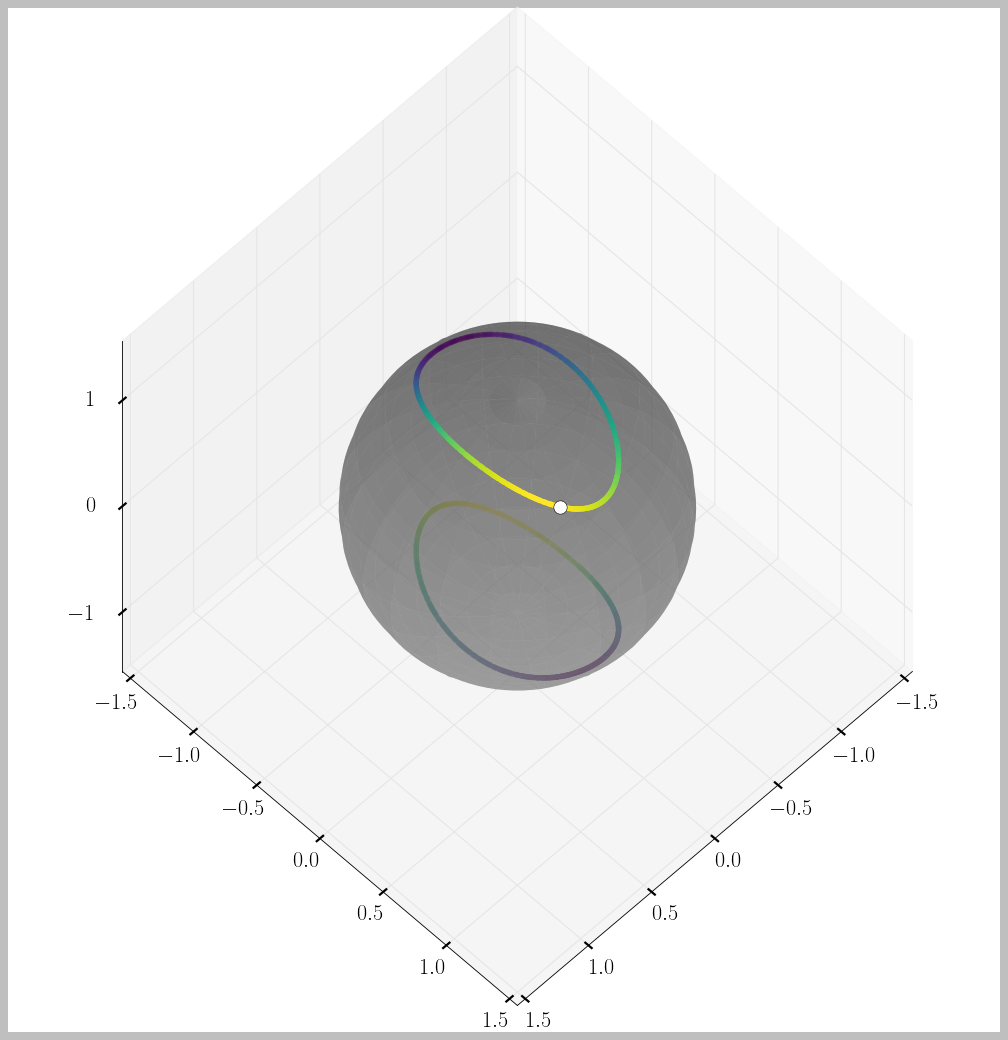

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

ax.plot_surface(
    x, y, z,
    rstride=5,
    cstride=5,
    color='gray',
    alpha=.5,
    linewidth=.0,
    shade=True
)


### we need to fix some z-fighting, or the plot looks like shit
eps = 1+1e-2

ax.scatter(
    eps*xs, eps*ys, eps*zs,
    c = xs + ys + zs,
    edgecolors = 'none',
    cmap=cm.viridis,
    s=25,
)

ax.scatter(
    -eps*xs, -eps*ys, -eps*zs,
    c = xs + ys + zs,
    edgecolors = 'none',
    cmap=cm.viridis,
    s=25,
)

ax.plot(
    [y0[0]], [y0[1]], [y0[2]],
    'o',
    markerfacecolor='white',
    markeredgecolor='black',
    markersize=12,
    zorder=6
)

[t.set_va('center') for t in ax.get_yticklabels()]
[t.set_ha('center') for t in ax.get_yticklabels()]

[t.set_va('center') for t in ax.get_xticklabels()]
[t.set_ha('center') for t in ax.get_xticklabels()]

[t.set_va('center') for t in ax.get_zticklabels()]
[t.set_ha('right')  for t in ax.get_zticklabels()]

ax.xaxis._axinfo['tick']['inward_factor']  = 0.1
ax.xaxis._axinfo['tick']['outward_factor'] = 0.1
ax.yaxis._axinfo['tick']['inward_factor']  = 0.1
ax.yaxis._axinfo['tick']['outward_factor'] = 0.1
ax.zaxis._axinfo['tick']['inward_factor']  = 0.1
ax.zaxis._axinfo['tick']['outward_factor'] = 0.1
ax.zaxis._axinfo['tick']['outward_factor'] = 0.1

ax.xaxis.set_major_locator(MultipleLocator(1/2))
ax.yaxis.set_major_locator(MultipleLocator(1/2))

ax.zaxis.set_major_locator(MultipleLocator(1))

# ax.grid(False)

ax.view_init(55, 45)

plt.savefig('euler.pdf')

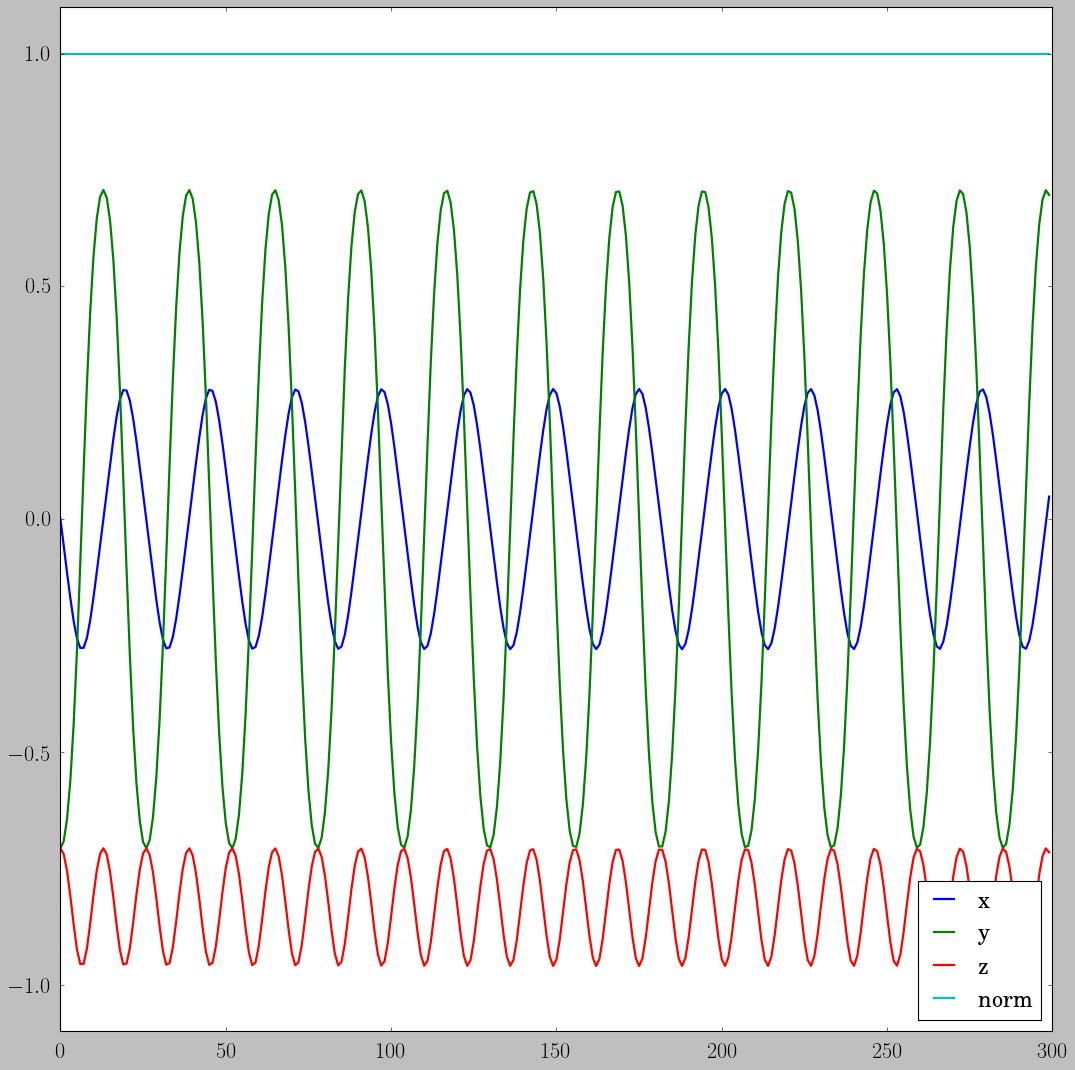

In [290]:
plt.plot(xs, label='x')
plt.plot(ys, label='y')
plt.plot(zs, label='z')
plt.plot(np.sqrt(xs**2 + ys**2 + zs**2), label='norm')
ymin, ymax = plt.ylim()
plt.ylim(1.1*ymin, ymax*1.1)
plt.legend(loc='lower right');

In [259]:
y0 = np.array([-4., 1., 4.])
y0 *= 1/linalg.norm(y0)

from scipy.integrate import solve_ivp

sol = solve_ivp(
    f, 
    t_span=(0., 250.),
    y0=y0,
    method='Radau'
)
scy = sol.y

scx, scy, scz = sol.y

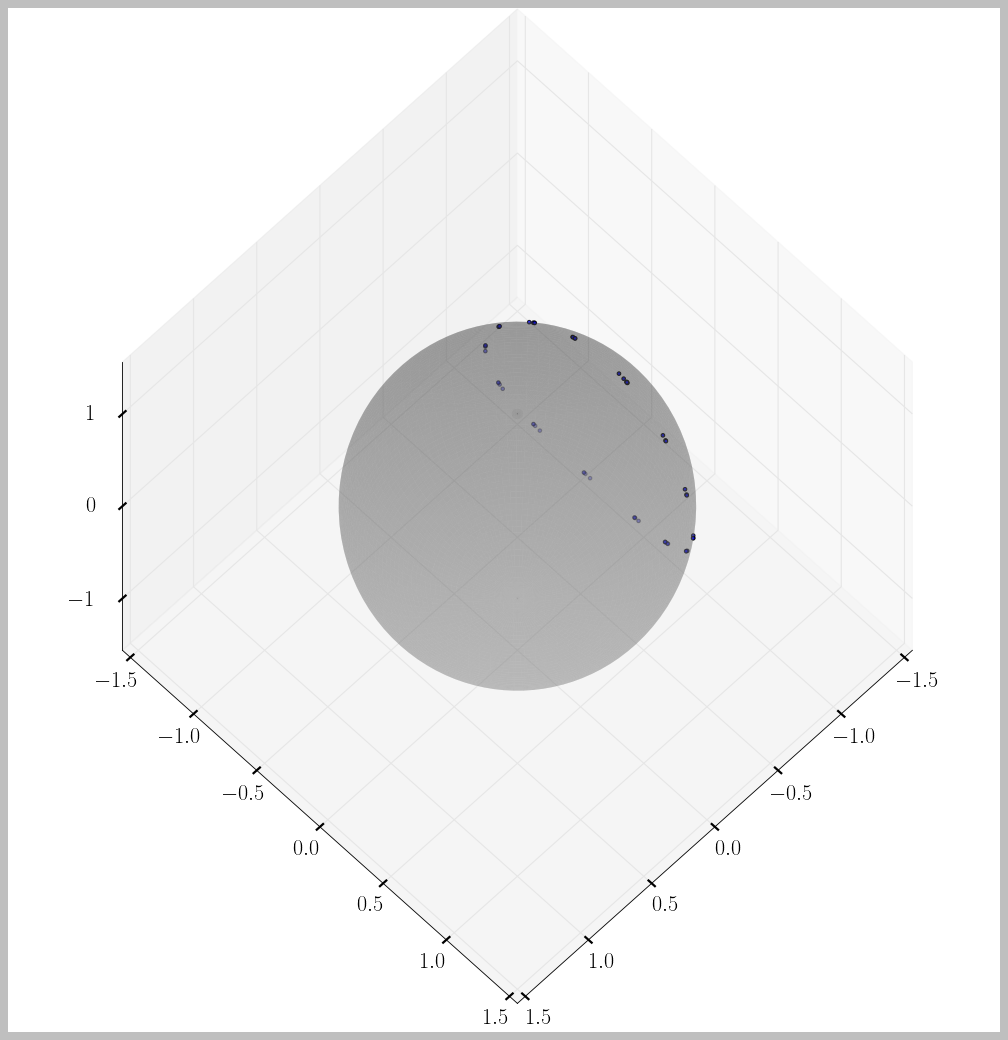

In [260]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='gray', alpha=0.3, linewidth=0
)

ax.scatter(scx, scy, scz, s=10)

[t.set_va('center') for t in ax.get_yticklabels()]
[t.set_ha('center') for t in ax.get_yticklabels()]

[t.set_va('center') for t in ax.get_xticklabels()]
[t.set_ha('center') for t in ax.get_xticklabels()]

[t.set_va('center') for t in ax.get_zticklabels()]
[t.set_ha('right')  for t in ax.get_zticklabels()]

ax.xaxis._axinfo['tick']['inward_factor'] = 0.1
ax.xaxis._axinfo['tick']['outward_factor'] = 0.1
ax.yaxis._axinfo['tick']['inward_factor'] = 0.1
ax.yaxis._axinfo['tick']['outward_factor'] = 0.1
ax.zaxis._axinfo['tick']['inward_factor'] = 0.1
ax.zaxis._axinfo['tick']['outward_factor'] = 0.1
ax.zaxis._axinfo['tick']['outward_factor'] = 0.1

ax.xaxis.set_major_locator(MultipleLocator(1/2))
ax.yaxis.set_major_locator(MultipleLocator(1/2))

ax.zaxis.set_major_locator(MultipleLocator(1))

# ax.grid(False)

ax.view_init(60, 45)

plt.show()

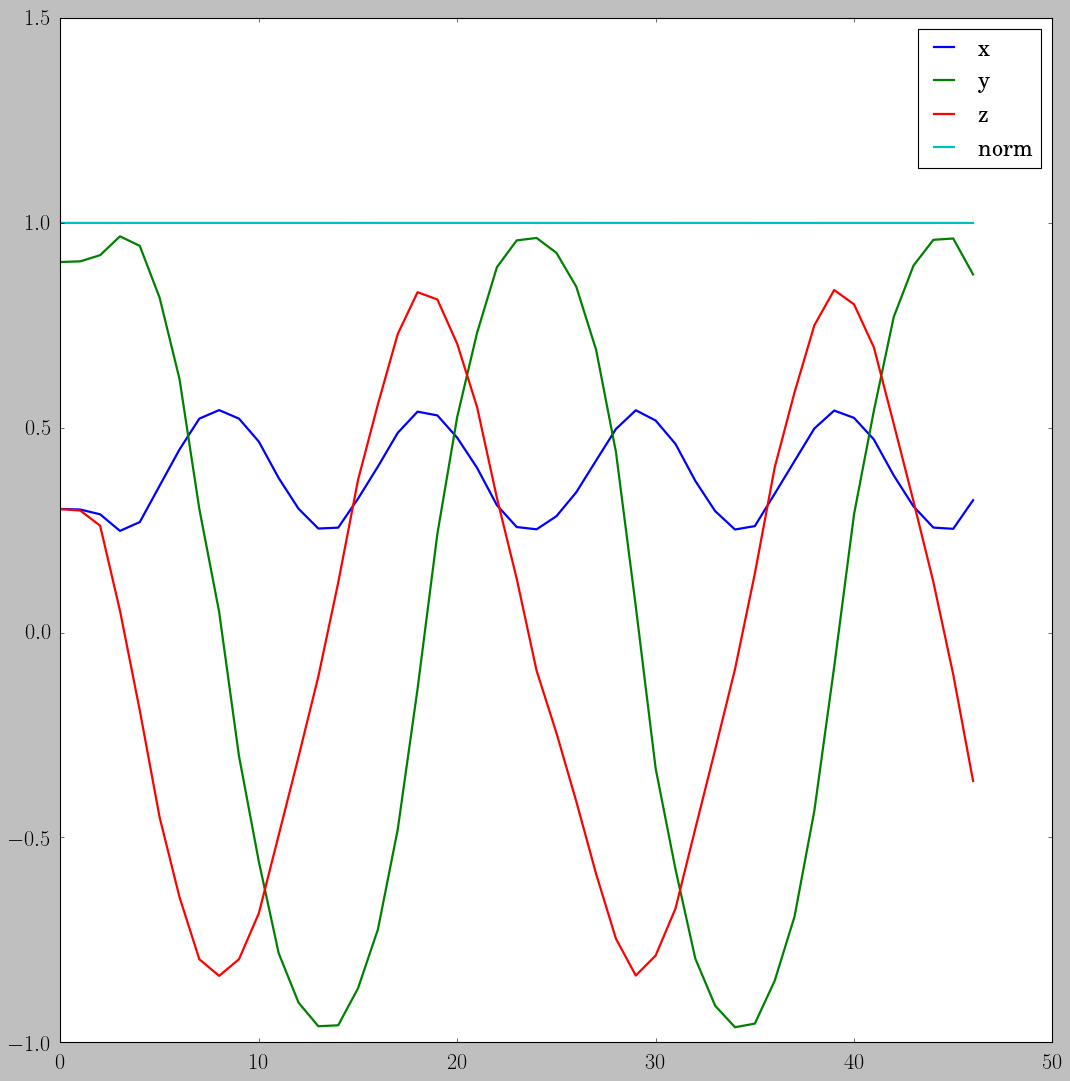

In [188]:
plt.plot(scx, label='x')
plt.plot(scy, label='y')
plt.plot(scz, label='z')
plt.plot(np.sqrt(scx**2 + scy**2 + scz**2), label='norm')
plt.legend()